# Классификация извержения вулкана с помощью библиотеки Scikit-learn

# 1. Problem Statement
Необходимо по снимкам с веб-камеры определять происходит в данный момент извержение вулкана или нет. 


## Import libraries

In [1]:


from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Common libraries
import os
import random
from glob import glob
from imutils import paths
from os import path
from joblib import dump, load
 
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')
 
# Handle table-like data and matrices
import numpy as np
import pandas as pd
 
# Modelling Algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
 
# Modelling Helpers
from sklearn.impute import SimpleImputer as Imputer
from sklearn.preprocessing import  Normalizer , scale
from sklearn.model_selection import train_test_split , StratifiedKFold, cross_val_score
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report, recall_score, f1_score, precision_score
from sklearn.metrics import plot_roc_curve 

 
# Visualisation
import cv2
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
#import seaborn as sns
 
# Configure visualisations
%matplotlib inline
mpl.style.use('ggplot')
 
plt.rcParams["axes.grid"] = False

In [3]:
project_path = '/content/drive/MyDrive/ML/Volcano/'
IMG_SIZE = (256, 256)

In [4]:
# Загрузка изображения и приведение к общему размеру 
def load_image(path, target_size=IMG_SIZE):
    image = cv2.imread(path)[...,::-1]
    image = cv2.resize(image, target_size)
    return image  

# Обработка изображения - размерность не меняется
def gradient_image(src):
    image = cv2.cvtColor(src, cv2.COLOR_BGR2RGB)
    image = cv2.GaussianBlur(image, (3, 3), 0)
    ##laplacian = cv2.Laplacian(image,cv2.CV_64F)
    sobelx = cv2.Sobel(image,cv2.CV_64F,1,0,ksize=5)
    sobely = cv2.Sobel(image,cv2.CV_64F,0,1,ksize=5)
    abs_grad_x = cv2.convertScaleAbs(sobelx)
    abs_grad_y = cv2.convertScaleAbs(sobely)    
    image = cv2.addWeighted(abs_grad_x, 0.5, abs_grad_y, 0.5, 0) 
    
    return image 

# Вычисляем угол и длину вектора градиента
def gradient_image_polar(src,ddepth = cv2.CV_32F, scale = 1, delta = 0 ):
    image = cv2.GaussianBlur(src, (3, 3), 0)
    grad_x = cv2.Sobel(image, ddepth, 1, 0, ksize=3, scale=scale, delta=delta, borderType=cv2.BORDER_DEFAULT)
    grad_y = cv2.Sobel(image, ddepth, 0, 1, ksize=3, scale=scale, delta=delta, borderType=cv2.BORDER_DEFAULT)
    g, theta = cv2.cartToPolar(grad_x, grad_y)
    return g, theta


# Вывод заданного количества изображений из указанной папки
def show_images(imagePaths, nrows = 1, ncols = 5):
  fig = plt.figure(figsize=(16, 8))
  for i, path in enumerate(imagePaths, 1):
      subplot = fig.add_subplot(nrows, ncols, i)
      subplot.set_title('%s' % path.split('/')[-2])
      img = cv2.imread(path)[...,::-1]
      img = cv2.resize(img, IMG_SIZE)
      plt.axis('off')
      plt.imshow(img)

In [5]:
class ColorDescriptor:
    
    def __init__(self, bins):
        # количество сегментов по y, x и channel
        self.bins = bins
 
    def describe(self, image):
        """ Вычисляем дескриптор изображения """
        
        features = []  # результирующий вектор дескриптора
        
        # переводим исходное изображение из цветового пространства BGR в HSV
        image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
 
        (h, w) = image.shape[:2]  # размеры изображения
        (cX, cY) = (int(w * 0.5), int(h * 0.5))  # координаты центра изображения
        
        # делим изображение на четыре равные части
        # и вычисляем координаты сегментов
        segments = [(0, cX, 0, cY), 
                    (cX, w, 0, cY),
                    (cX, w, cY, h),
                    (0, cX, cY, h)]
 
        # готовим маску в виде эллипса для выделения 
        # дескрипторов центральной части изображения
        (axesX, axesY) = (int(w * 0.75) // 2, int(h * 0.75) // 2)
        ellip_mask = np.zeros(image.shape[:2], dtype = np.uint8)
        cv2.ellipse(ellip_mask, (cX, cY), (axesX, axesY), 0, 0, 360, 255, -1)
 
        # итерируем по четырем сегментам и вычисляем дескрипторы
        for (startX, endX, startY, endY) in segments:
            # формируем маску сегмента
            corner_mask = np.zeros(image.shape[:2], dtype = np.uint8)
            cv2.rectangle(corner_mask, (startX, startY), (endX, endY), 255, -1)
            cornerMask = cv2.subtract(corner_mask, ellip_mask)  # вычитаем пересечение с эллипсом 
 
            # строим цветовую гистограмму с учетом маски сегмента
            hist = self.histogram(image, corner_mask)
            features.extend(hist)
 
        # вычисляем гистограму для центральной области
        hist = self.histogram(image, ellip_mask)
        features.extend(hist)
 
        # возвращаем вектор полученный вектор дескрипторов
        return features
    
    def histogram(self, image, mask):
        """ Вычисляет гистограмму в области, заданной маской """
        
        # задаем диапазоны изменений по каналам
        ranges = [0, 180,  # Hue
                  0, 256,  # Saturation
                  0, 256]  # Value
        
        # вычисляем 3D гистограмму (x, y, channel)
        hist = cv2.calcHist([image], [0, 1, 2], mask,
                            self.bins, ranges = ranges)
        
        # нормируем гистограмму
        hist = cv2.normalize(hist, np.zeros_like(hist)).flatten()

        return hist


# 2. Data Understanding

Набор данных - фотографии вуканов, разделенные на два класса:

'**alert**' (0) -  на фото зафиксирована любая активность на вулкане: парогазовый столб, взрыв, потоки лавы, 

'**normal**' (1) - нормальное состояние, никакой активности вулкана не отмечается, либо видимость не позволяет определить более точно. 

Классификацию изображений будем проводить с помощью алгоритмов машинного обучения из библиотеки Scikit-learn:
 - Logistic Regression
 - Decision Tree
 - Random Forest 
 - Gradient Boosting 
 - Bagging 

Для использования классификаторов исходное изображение необходимо предварительно обрабатать, провести feature engineering  и добавить новые признаки с помощью нескольких дескрипторов изображений.


### 2.1 Загрузка данных

Подготовим три датасета. 
Датасеты для обучения и вализации разбиты на классы. Класс соответствует названию папки.
Датасет дл теста не разбит по классам.

In [6]:
train = []
train_labels = []

validation = []
validation_labels = []
 
test = []

imagePaths_train = sorted(list(paths.list_images(path.join(project_path,'data/processed/train'))))
for imagePath in imagePaths_train:
    image = load_image(imagePath)
    train.append(image)
    label = imagePath.split(os.path.sep)[-2]
    train_labels.append(label) 
    
imagePaths_validation = sorted(list(paths.list_images(path.join(project_path,'data/processed/test'))))
for imagePath in imagePaths_validation:
    image = load_image(imagePath)
    validation.append(image)
    label = imagePath.split(os.path.sep)[-2]
    validation_labels.append(label)     

imagePaths_test = sorted(list(paths.list_images(path.join(project_path,'data/raw/img'))))
for imagePath in imagePaths_test:
    image = load_image(imagePath)
    test.append(image)

# перемешиваем выборку для получения разных результатов при анализе данных
random.shuffle(imagePaths_train)
random.shuffle(imagePaths_validation)


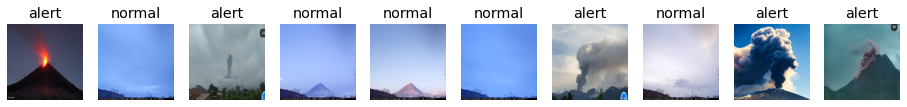

In [60]:
show_images(imagePaths_train[0:10], 1,  10)

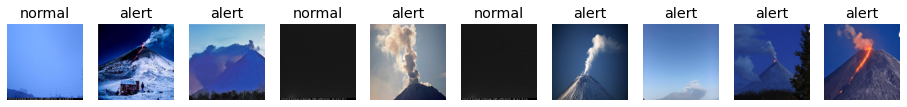

In [61]:
show_images(imagePaths_validation[0:10], 1,  10)

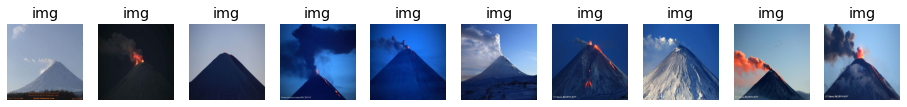

In [62]:
show_images(imagePaths_test[0:10], 1,  10)

### 2.2 Анализ данных

Для анализа данных пробуем использовать различные фильтры, переводим в различные цветовые схемы. 

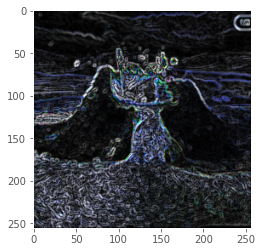

In [63]:
src = cv2.GaussianBlur(train[5], (3, 3), 0)
laplacian = cv2.Laplacian(src,cv2.CV_64F)
src = cv2.cvtColor(src, cv2.COLOR_BGR2HSV)  
sobelx = cv2.Sobel(src,cv2.CV_64F,1,0,ksize=3)
sobely = cv2.Sobel(src,cv2.CV_64F,0,1,ksize=3)
abs_grad_x = cv2.convertScaleAbs(sobelx)
abs_grad_y = cv2.convertScaleAbs(sobely)
    
grad = cv2.addWeighted(abs_grad_x, 0.5, abs_grad_y, 0.5, 0) 
grad = cv2.cvtColor(grad, cv2.COLOR_HSV2BGR)  
plt.imshow(grad)

In [64]:
grad.shape

(256, 256, 3)

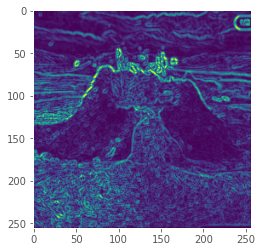

In [65]:
# второй вариант  сокращение размерности  за счет перевода cv2.COLOR_BGR2GRAY
scale = 1
delta = 0
#ddepth = cv2.CV_16S
ddepth = cv2.CV_32F
src = cv2.GaussianBlur(train[5], (3, 3), 0)
gray = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY)  
grad_x = cv2.Sobel(gray, ddepth, 1, 0, ksize=3, scale=scale, delta=delta, borderType=cv2.BORDER_DEFAULT)
grad_y = cv2.Sobel(gray, ddepth, 0, 1, ksize=3, scale=scale, delta=delta, borderType=cv2.BORDER_DEFAULT)
abs_grad_x = cv2.convertScaleAbs(grad_x)
abs_grad_y = cv2.convertScaleAbs(grad_y)
    
grad = cv2.addWeighted(abs_grad_x, 0.5, abs_grad_y, 0.5, 0)
#grad = cv2.cvtColor(grad, cv2.COLOR_HSV2BGR)  
plt.imshow(grad)

In [66]:
grad.shape

(256, 256)

Пробуем строить границы и контуры на изображении, используя метод Суперпиксель.

In [67]:
from cv2 import ximgproc

seeds = None
display_mode = 0
num_superpixels = 20
prior = 4
num_levels = 9
num_histogram_bins = 5
num_iterations = 1000

img = train[0]
# преобразуем пространство цветов
converted_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

height,width,channels = converted_img.shape

# инициализируем алгоритм
seeds = ximgproc.createSuperpixelSEEDS(width, height, channels,
            num_superpixels, num_levels, prior, num_histogram_bins)

# выполняем num_iterations шагов
seeds.iterate(converted_img, num_iterations)

# получаем разметку пикселей
labels = seeds.getLabels()

# получаем маску контуров
mask = seeds.getLabelContourMask(thick_line=False)

# инвертируем маску
mask_inv = cv2.bitwise_not(mask)

# зануляем пикселы исходной картинки на границах
result_bg = cv2.bitwise_and(img, img, mask=mask_inv)

# создаем изображение контуров
color_img = np.zeros((height,width,3), np.uint8)
color_img[:] = (0, 255, 0)
result_fg = cv2.bitwise_and(color_img, color_img, mask=mask)

# совмещаем границы с исходным изображением
result = cv2.add(result_bg, result_fg)

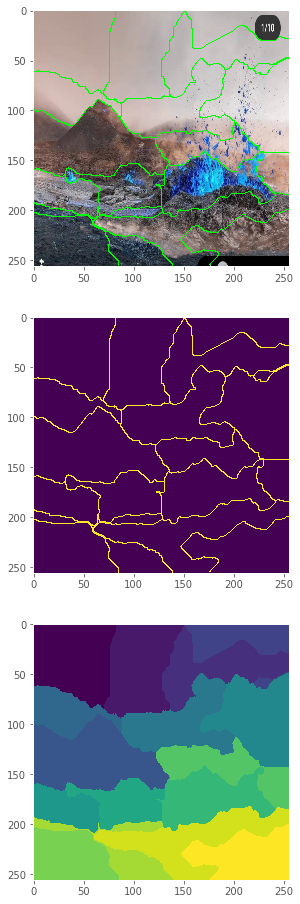

In [68]:
imgs = [cv2.cvtColor(result, cv2.COLOR_BGR2RGB),
        mask, labels]
fig = plt.figure(figsize=(10, 16))
for i, e in enumerate(imgs, 1):
    subplot = fig.add_subplot(3, 1, i)
    plt.imshow(e);

Посмотрим, как можно исползовать метод характерных точек. Вычислим для них дескрипторы, затем опредлим соответствия между шаблоном и сценой (двумя изображениями).

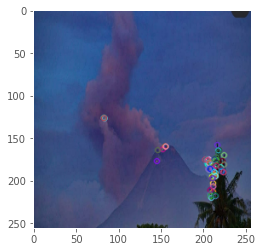

In [69]:
# инициализируем детектор точек
orb = cv2.ORB_create()
img = train[28]
# запускаем поиск точек и вычисление дескрипторов
kp1, des1 = orb.detectAndCompute(img, None)
img1_kp = cv2.drawKeypoints(img, kp1, np.zeros_like(img))
plt.imshow(img1_kp)


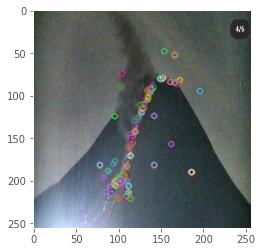

In [70]:
img_find = train[32]
kp2, des2 = orb.detectAndCompute(img_find, None)
img2_kp = cv2.drawKeypoints(img_find, kp2, np.zeros_like(img_find))
plt.imshow(img2_kp)

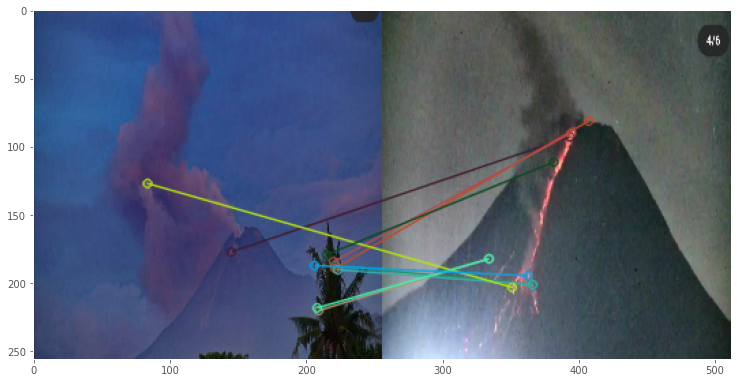

(<matplotlib.image.AxesImage at 0x7ff0a056c990>, None)

In [71]:
# матчинг полным перебором - brute force matching
# мера расстояния - расстояние Хэмминга (количество несовпадающих компонент)
bf = cv2.BFMatcher(cv2.NORM_HAMMING)

# матчинг
matches = bf.match(des1, des2)

# сортируем результат по убыванию расстояния
matches = sorted(matches, key = lambda x: x.distance)

# выводим 10 лучших совпадений
img3 = np.zeros_like(img_find)
img3 = cv2.drawMatches(img, kp1, img_find, kp2, matches[:10], img3, flags=2)

fig = plt.gcf()
fig.set_size_inches(12.5, 8.5)
plt.imshow(img3),plt.show()

#  3.  Data Preparation

## 3.1 Feature Engineering

Рассчитаем несколько дескрипторов изображений



### Гистограмма изображения, постороенная с использованием фильтра Собеля

Вычисляем градиент и гистограммы для изображения. Для этого переводим градиент в полярные координаты, вычисляем гистограмму (используя угол и длину вектора градиента) и нормируем ее.

In [7]:
train_grad = np.zeros_like(train)
train_g = np.zeros_like(train).astype(float)
train_theta = np.zeros_like(train).astype(float)

for i in range(len(train)):  
    train_g[i], train_theta[i] = gradient_image_polar(train[i])  # длина вектора и угол 
    train_grad[i] = gradient_image(train[i])  # градиент


validation_grad = np.zeros_like(validation)
validation_g = np.zeros_like(validation).astype(float)
validation_theta = np.zeros_like(validation).astype(float)

for i in range(len(validation)):
    validation_g[i], validation_theta[i] = gradient_image_polar(validation[i]) 
    validation_grad[i] = gradient_image(validation[i])
    

test_grad = np.zeros_like(test)
test_g = np.zeros_like(test).astype(float)
test_theta = np.zeros_like(test).astype(float)

for i in range(len(test)):
    test_g[i], test_theta[i] = gradient_image_polar(test[i]) 
    test_grad[i] = gradient_image(test[i])

In [8]:
train_grad.shape   # рассчитывается для анализа данных, в моделях не учитывается

(80, 256, 256, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


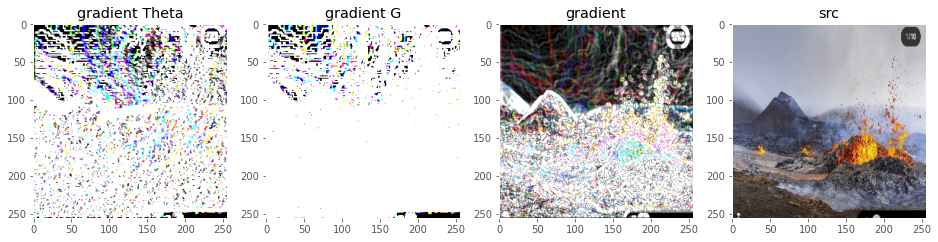

In [74]:
fig = plt.figure(figsize=(16, 8))
subplot = fig.add_subplot(1, 4, 1)
subplot.set_title('gradient Theta')
img = train_theta[0]
plt.imshow(img)
subplot = fig.add_subplot(1, 4, 2)
subplot.set_title('gradient G')
img = train_g[0]
plt.imshow(img)
subplot = fig.add_subplot(1, 4, 3)
subplot.set_title('gradient')
img = train_grad[0]
plt.imshow(img)
subplot = fig.add_subplot(1, 4, 4)
subplot.set_title('src') 
img = train[0]
plt.imshow(img)

In [8]:
# Гистограммы вычисляются с учетом длины вектора градиента
train_hist = np.zeros((len(train), 64))
for i in range(len(train)):
    hist, borders = np.histogram(train_theta[i],
                                 bins=64,
                                 range=(0., 2. * np.pi),
                                 weights=train_g[i])
    train_hist[i] = hist

validation_hist = np.zeros((len(validation), 64))
for i in range(len(validation)):
    hist, borders = np.histogram(validation_theta[i],
                                 bins=64,
                                 range=(0., 2. * np.pi),
                                 weights=validation_g[i])
    validation_hist[i] = hist

test_hist = np.zeros((len(test), 64))
for i in range(len(test)):
    hist, borders = np.histogram(test_theta[i],
                                 bins=64,
                                 range=(0., 2. * np.pi),
                                 weights=test_g[i])
    test_hist[i] = hist
    
# По умолчанию используется L2 норма - нормируем вектор гистограмм
train_hist = train_hist / np.linalg.norm(train_hist, axis=1)[:, None]
validation_hist = validation_hist / np.linalg.norm(validation_hist, axis=1)[:, None]
test_hist = test_hist / np.linalg.norm(test_hist, axis=1)[:, None]

In [9]:
# проверяем размерность
print(len(train_hist), "train obs. descriptor shape: ", len(train_hist[0]))
print(len(validation_hist), "validation obs. descriptor shape: ", len(validation_hist[0]))
print(len(test_hist),"test obs. descriptor shape: ", len(test_hist[0]) )


80 train obs. descriptor shape:  64
30 validation obs. descriptor shape:  64
45 test obs. descriptor shape:  64


In [11]:
test_hist[0]

array([0.11735462, 0.05013934, 0.05884957, 0.05700774, 0.0596333 ,
       0.05265203, 0.04402444, 0.10808421, 0.02955859, 0.05017538,
       0.06072872, 0.07305742, 0.07846953, 0.07157918, 0.09325299,
       0.08972363, 0.1861923 , 0.08928284, 0.08694144, 0.0822214 ,
       0.08862404, 0.0756144 , 0.05655787, 0.03263022, 0.14830829,
       0.05103865, 0.06633935, 0.08781679, 0.07303179, 0.06992283,
       0.05436589, 0.0362965 , 0.16062645, 0.05337189, 0.07111131,
       0.08259025, 0.09545951, 0.09804124, 0.10618587, 0.22282452,
       0.16971691, 0.17328144, 0.2075822 , 0.22140296, 0.21909394,
       0.23560663, 0.23391831, 0.21681397, 0.30963697, 0.19348056,
       0.17068407, 0.16154273, 0.12646911, 0.13989133, 0.1731681 ,
       0.15609687, 0.13476771, 0.0603183 , 0.05588345, 0.05315421,
       0.04772047, 0.05072419, 0.0462091 , 0.03252657])

### Цветовая гистограмма 5 блоков

Дескриптор, построенный на основе цветовой гистограммы для 5 частей изображения:  4 квадранта и центральный эллипс 

In [10]:
cd = ColorDescriptor((256, 256, 3))

train_histogram = []

for i in range(len(train)):
    train_histogram.append(cd.describe(train[i]))
    
validation_histogram = []

for i in range(len(validation)):
    validation_histogram.append(cd.describe(validation[i]))

test_histogram = []

for i in range(len(test)):
    test_histogram.append(cd.describe(test[i]))

print(len(train_histogram), "train obs. descriptor shape: ", len(train_histogram[0]))
print(len(validation_histogram), "validation obs. descriptor shape: ", len(validation_histogram[0]))
print(len(test_histogram),"test obs. descriptor shape: ", len(test_histogram[0]) )

80 train obs. descriptor shape:  983040
30 validation obs. descriptor shape:  983040
45 test obs. descriptor shape:  983040


In [79]:
train_histogram[0][115:120]

[0.0, 0.0, 0.011444807, 0.0009952006, 0.0]

### Дескриптор HOGD

In [11]:
# задаем размерность дескриптора
hog = cv2.HOGDescriptor()  
img = cv2.resize(train_grad[0], (128,128))
h = hog.compute(np.uint8(img))
print('Descriptor size: %d' % len(h))

Descriptor size: 34020


In [12]:
train_descriptor = np.zeros((len(train_grad), 34020))
for i in range(len(train_grad)):
    img = cv2.resize(train_grad[i], (128,128))
    h = hog.compute(np.uint8(img))
    train_descriptor[i] = h.reshape(-1)
    
validation_descriptor = np.zeros((len(validation_grad), 34020))
for i in range(len(validation_grad)):
    img = cv2.resize(validation_grad[i], (128,128))
    h = hog.compute(np.uint8(img))
    validation_descriptor[i] = h.reshape(-1)
    
test_descriptor = np.zeros((len(test_grad), 34020))
for i in range(len(test_grad)):
    img = cv2.resize(test_grad[i], (128,128))
    h = hog.compute(np.uint8(img))
    test_descriptor[i] = h.reshape(-1)

In [13]:
# проверяем размерность 
print(len(train_descriptor[0]), "train  descriptor shape: ", len(train_descriptor.shape))
print(len(validation_descriptor[0]), "validation  descriptor shape: ", len(validation_descriptor.shape))
print(len(test_descriptor[0]),"test  descriptor shape: ", len(test_descriptor.shape))

34020 train  descriptor shape:  2
34020 validation  descriptor shape:  2
34020 test  descriptor shape:  2


In [83]:
train_descriptor[0]

array([0.09101032, 0.10390376, 0.13260281, ..., 0.15680987, 0.08050642,
       0.07440057])

## 3.2 Создание датасетов для классификации

Для классификации соединим полученные на предыдущем этапе признаки в общий датасет.


In [14]:
# проверяем размерность
print('Обучающая выборка X ', len(train))
print('Обучающая выборка Y ', len(train_labels))
print('массив градиентов   ', train_grad.shape)
print('длины векторов      ', train_g.shape)
print('угол                ', train_theta.shape)

print('HOGD дескриптор     ', train_descriptor.shape)
print('дескриптор Собеля   ', train_hist.shape)
print('5 блочный дескриптор', len(train_histogram[0]))


Обучающая выборка X  80
Обучающая выборка Y  80
массив градиентов    (80, 256, 256, 3)
длины векторов       (80, 256, 256, 3)
угол                 (80, 256, 256, 3)
HOGD дескриптор      (80, 34020)
дескриптор Собеля    (80, 64)
5 блочный дескриптор 983040


In [15]:
x_train = np.hstack((train_descriptor,train_hist))
x_val = np.hstack((validation_descriptor,validation_hist))
x_test = np.hstack((test_descriptor,test_hist))
x_test.shape

(45, 34084)

Объединяем все новые признаки в итоговый датасет для обучения модели:

In [16]:
x_train = np.hstack((x_train,train_histogram))
x_val = np.hstack((x_val,validation_histogram))
x_test = np.hstack((x_test,test_histogram))
x_train.shape

(80, 1017124)

In [19]:
pd.DataFrame(x_train[:1])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,1017084,1017085,1017086,1017087,1017088,1017089,1017090,1017091,1017092,1017093,1017094,1017095,1017096,1017097,1017098,1017099,1017100,1017101,1017102,1017103,1017104,1017105,1017106,1017107,1017108,1017109,1017110,1017111,1017112,1017113,1017114,1017115,1017116,1017117,1017118,1017119,1017120,1017121,1017122,1017123
0,0.09101,0.103904,0.132603,0.127278,0.212455,0.180413,0.238077,0.161066,0.125561,0.111894,0.166046,0.068399,0.056629,0.203324,0.254263,0.25811,0.25811,0.115768,0.084291,0.028678,0.028585,0.070248,0.093355,0.248684,0.25811,0.25811,0.133391,0.031175,0.056265,0.047733,0.048875,0.134984,0.25811,0.25811,0.25811,0.075586,0.12253,0.149046,0.118239,0.05348,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
y_train = train_labels
y_val = validation_labels

In [89]:
y_train[1]

'alert'

# 4. Modeling 

Для решения бинарной классификации изображений воспользуемся библиотекой Scikit-learn.




## 4.1 Классификаторы
Логистическая регрессия

In [24]:
lr_clf = LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
lr_clf.fit(x_train, y_train)   
 
y_predict_lr = lr_clf.predict(x_val)
y_predict_test_lr = lr_clf.predict(x_test)
 
recall_average_lr = recall_score(y_val, y_predict_lr, average="binary", pos_label='normal') 
accuracy_average_lr = accuracy_score(y_val, y_predict_lr)

print('F1 : %s' % f1_score(y_val, y_predict_lr, average='weighted'))
print('Precision : %s' % precision_score(y_val, y_predict_lr, average='weighted'))
 
print('Accuracy: %s' % accuracy_average_lr)
print('Recall: %s' % recall_average_lr)
print(classification_report(y_val, y_predict_lr))

F1 : 0.8685185185185186
Precision : 0.8781297134238311
Accuracy: 0.8666666666666667
Recall: 0.9090909090909091
              precision    recall  f1-score   support

       alert       0.94      0.84      0.89        19
      normal       0.77      0.91      0.83        11

    accuracy                           0.87        30
   macro avg       0.86      0.88      0.86        30
weighted avg       0.88      0.87      0.87        30



In [91]:
accuracies = cross_val_score(estimator=lr_clf, X=x_train, y=y_train, cv=3)
 
print('Test Accuracies : {0}'.format([round(accuracy, 8) for accuracy in accuracies]))
print('Mean Accuracy : {0:.8f}'.format(accuracies.mean()))
print('Standard Deviation : {0:.8f}'.format(accuracies.std()))

Test Accuracies : [0.81481481, 0.88888889, 0.84615385]
Mean Accuracy : 0.84995252
Standard Deviation : 0.03035967


In [25]:
from sklearn import svm


C = 1.0  # = self._alpha in our algorithm
svc_clf = svm.SVC(C=0.01, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
#model1 = svm.LinearSVC(C=C, max_iter=10000)
#model1 = svm.SVC(kernel='rbf', gamma=0.7, C=C)
#model1 = svm.SVC(kernel='poly', degree=3, gamma='auto', C=C)

svc_clf.fit(x_train, y_train)
y_predict_svc = svc_clf.predict(x_val)
print(recall_score(y_val, y_predict_svc, average=None))


y_predict_test_svc = svc_clf.predict(x_test)
 
recall_average_svc = recall_score(y_val, y_predict_svc, average="binary", pos_label='normal') 
accuracy_average_svc = accuracy_score(y_val, y_predict_svc)

print('F1 : %s' % f1_score(y_val, y_predict_svc, average='weighted'))
print('Precision : %s' % precision_score(y_val, y_predict_svc, average='weighted')) 
print('Accuracy: %s' % accuracy_average_svc)
print('Recall: %s' % recall_average_svc)
print(classification_report(y_val, y_predict_svc))

[0.84210526 0.90909091]
F1 : 0.8685185185185186
Precision : 0.8781297134238311
Accuracy: 0.8666666666666667
Recall: 0.9090909090909091
              precision    recall  f1-score   support

       alert       0.94      0.84      0.89        19
      normal       0.77      0.91      0.83        11

    accuracy                           0.87        30
   macro avg       0.86      0.88      0.86        30
weighted avg       0.88      0.87      0.87        30



In [23]:
 
from sklearn.model_selection import GridSearchCV
 
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100] }
clf = GridSearchCV(svc_clf , param_grid)
GridSearchCV(cv=None,
             estimator=LogisticRegression(C=1.0, intercept_scaling=1,   
               dual=False, fit_intercept=True, penalty='l2', tol=0.0001),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100 ]})

GridSearchCV(cv=None, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [24]:
 grid_search = clf.fit(x_train, y_train)
print("Best score: %0.3f" % grid_search.best_score_)
print(grid_search.best_estimator_)

    # best prarams
print('best prarams:', clf.best_params_)

print('-----grid search end------------')
#print('on all train set')
#scores = cross_val_score(grid_search.best_estimator_, x_train, y_train, cv=3, scoring='accuracy')
#print(scores.mean(), scores)
#print('on test set')
#scores = cross_val_score(grid_search.best_estimator_, x_test, y_test, cv=3, scoring='accuracy')
#print(scores.mean(), scores) 

Best score: 0.887
SVC(C=0.01, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
best prarams: {'C': 0.01}
-----grid search end------------


Деревья решений

In [26]:
dt_clf = DecisionTreeClassifier()
dt_clf.fit(x_train, y_train)   
 
y_predict_dt = dt_clf.predict(x_val)
y_predict_test_dt = dt_clf.predict(x_test)
 
recall_average_dt = recall_score(y_val, y_predict_dt, average="binary", pos_label='normal') 
accuracy_average_dt = accuracy_score(y_val, y_predict_dt)
 
print('F1 : %s' % f1_score(y_val, y_predict_dt, average='weighted'))
print('Precision : %s' % precision_score(y_val, y_predict_dt, average='weighted')) 
print('Accuracy: %s' % accuracy_average_dt)
print('Recall: %s' % recall_average_dt)
print(classification_report(y_val, y_predict_dt))

F1 : 0.8685185185185186
Precision : 0.8781297134238311
Accuracy: 0.8666666666666667
Recall: 0.9090909090909091
              precision    recall  f1-score   support

       alert       0.94      0.84      0.89        19
      normal       0.77      0.91      0.83        11

    accuracy                           0.87        30
   macro avg       0.86      0.88      0.86        30
weighted avg       0.88      0.87      0.87        30



In [98]:
accuracies = cross_val_score(estimator=dt_clf, X=x_train, y=y_train, cv=3)

print('Test Accuracies : {0}'.format([round(accuracy, 8) for accuracy in accuracies]))
print('Mean Accuracy : {0:.8f}'.format(accuracies.mean()))
print('Standard Deviation : {0:.8f}'.format(accuracies.std()))

Test Accuracies : [0.77777778, 0.77777778, 0.76923077]
Mean Accuracy : 0.77492877
Standard Deviation : 0.00402910


RandomForestClassifier

In [27]:
rf_clf = RandomForestClassifier(n_estimators=50, max_depth=6,   n_jobs=-1)
rf_clf.fit(x_train, y_train)   
y_predict_rf = rf_clf.predict(x_val)
y_predict_test_rf = rf_clf.predict(x_test)

recall_average_rf = recall_score(y_val, y_predict_rf, average="binary", pos_label='normal') 
accuracy_average_rf = accuracy_score(y_val, y_predict_rf)

print('F1 : %s' % f1_score(y_val, y_predict_rf, average='weighted'))
print('Precision : %s' % precision_score(y_val, y_predict_rf, average='weighted')) 
print('Accuracy: %s' % accuracy_average_rf)
print('Recall: %s' % recall_average_rf)
print(classification_report(y_val, y_predict_rf))

F1 : 0.8685185185185186
Precision : 0.8781297134238311
Accuracy: 0.8666666666666667
Recall: 0.9090909090909091
              precision    recall  f1-score   support

       alert       0.94      0.84      0.89        19
      normal       0.77      0.91      0.83        11

    accuracy                           0.87        30
   macro avg       0.86      0.88      0.86        30
weighted avg       0.88      0.87      0.87        30



In [100]:
accuracies = cross_val_score(estimator=rf_clf, X=x_train, y=y_train, cv=3)

print('Test Accuracies : {0}'.format([round(accuracy, 8) for accuracy in accuracies]))
print('Mean Accuracy : {0:.8f}'.format(accuracies.mean()))
print('Standard Deviation : {0:.8f}'.format(accuracies.std()))

Test Accuracies : [0.77777778, 0.88888889, 0.88461538]
Mean Accuracy : 0.85042735
Standard Deviation : 0.05140062


BaggingClassifier

In [28]:
bg_clf = BaggingClassifier(n_estimators=30, n_jobs=-1)
bg_clf.fit(x_train, y_train)   

y_predict_bg = bg_clf.predict(x_val)
y_predict_test_bg = bg_clf.predict(x_test)

recall_average_bg = recall_score(y_val, y_predict_bg, average="binary", pos_label='normal') 
accuracy_average_bg = accuracy_score(y_val, y_predict_bg)

print('F1 : %s' % f1_score(y_val, y_predict_bg, average='weighted'))
print('Precision : %s' % precision_score(y_val, y_predict_bg, average='weighted')) 
print('Accuracy: %s' % accuracy_average_bg)
print('Recall: %s' % recall_average_bg)
print(classification_report(y_val, y_predict_bg))

F1 : 0.9333333333333333
Precision : 0.9333333333333333
Accuracy: 0.9333333333333333
Recall: 0.9090909090909091
              precision    recall  f1-score   support

       alert       0.95      0.95      0.95        19
      normal       0.91      0.91      0.91        11

    accuracy                           0.93        30
   macro avg       0.93      0.93      0.93        30
weighted avg       0.93      0.93      0.93        30



In [ ]:
accuracies = cross_val_score(estimator=bg_clf, X=x_train, y=y_train, cv=3)

print('Test Accuracies : {0}'.format([round(accuracy, 8) for accuracy in accuracies]))
print('Mean Accuracy : {0:.8f}'.format(accuracies.mean()))
print('Standard Deviation : {0:.8f}'.format(accuracies.std()))

GradientBoostingClassifier

In [29]:
gb_clf = GradientBoostingClassifier(learning_rate=0.07, max_depth=5)
gb_clf.fit(x_train, y_train)   

y_predict_gb = gb_clf.predict(x_val)
y_predict_test_gb = gb_clf.predict(x_test)

recall_average_gb = recall_score(y_val, y_predict_gb, average="binary", pos_label='normal') 
accuracy_average_gb = accuracy_score(y_val, y_predict_gb)

print('F1 : %s' % f1_score(y_val, y_predict_gb, average='weighted'))
print('Precision : %s' % precision_score(y_val, y_predict_gb, average='weighted')) 
print('Accuracy: %s' % accuracy_average_gb)
print('Recall: %s' % recall_average_gb)
print(classification_report(y_val, y_predict_gb))

F1 : 0.8685185185185186
Precision : 0.8781297134238311
Accuracy: 0.8666666666666667
Recall: 0.9090909090909091
              precision    recall  f1-score   support

       alert       0.94      0.84      0.89        19
      normal       0.77      0.91      0.83        11

    accuracy                           0.87        30
   macro avg       0.86      0.88      0.86        30
weighted avg       0.88      0.87      0.87        30



In [ ]:
accuracies = cross_val_score(estimator=gb_clf, X=x_train, y=y_train, cv=3)
 
print('Test Accuracies : {0}'.format([round(accuracy, 8) for accuracy in accuracies]))
print('Mean Accuracy : {0:.8f}'.format(accuracies.mean()))
print('Standard Deviation : {0:.8f}'.format(accuracies.std()))

## 4.2 Оценка классификаторов

In [30]:
result_ml = pd.DataFrame()
result_ml = result_ml.append({'model' : 'LogisticRegression',
                              'classifier' : 'lr_clf',
                              'recall' : recall_average_lr,
                              'accuracy' : accuracy_average_lr,
                              } ,  ignore_index=True)
result_ml = result_ml.append({'model' : 'DecisionTreeClassifier',
                              'classifier' : 'dt_clf',
                              'recall' : recall_average_dt,
                              'accuracy' : accuracy_average_dt,
                              } ,  ignore_index=True)
result_ml = result_ml.append({'model' : 'SVC',
                              'classifier' : 'svc_clf',
                              'recall' : recall_average_svc,
                              'accuracy' : accuracy_average_svc,
                              } ,  ignore_index=True)
result_ml = result_ml.append({'model' : 'RandomForestClassifier',
                              'classifier' : 'rf_clf',
                              'recall' : recall_average_rf,
                              'accuracy' : accuracy_average_rf,
                              } ,  ignore_index=True)
result_ml = result_ml.append({'model' : 'BaggingClassifier',
                              'classifier' : 'bg_clf',
                              'recall' : recall_average_bg,
                              'accuracy' : accuracy_average_bg,
                              } ,  ignore_index=True)
result_ml = result_ml.append({'model' : 'GradientBoostingClassifier',
                              'classifier' : 'gb_clf',
                              'recall' : recall_average_gb,
                              'accuracy' : accuracy_average_gb,
                              } ,  ignore_index=True)

In [31]:
result_ml

,accuracy,classifier,model,recall
0,0.866667,lr_clf,LogisticRegression,0.909091
1,0.866667,dt_clf,DecisionTreeClassifier,0.909091
2,0.866667,svc_clf,SVC,0.909091
3,0.866667,rf_clf,RandomForestClassifier,0.909091
4,0.933333,bg_clf,BaggingClassifier,0.909091
5,0.866667,gb_clf,GradientBoostingClassifier,0.909091


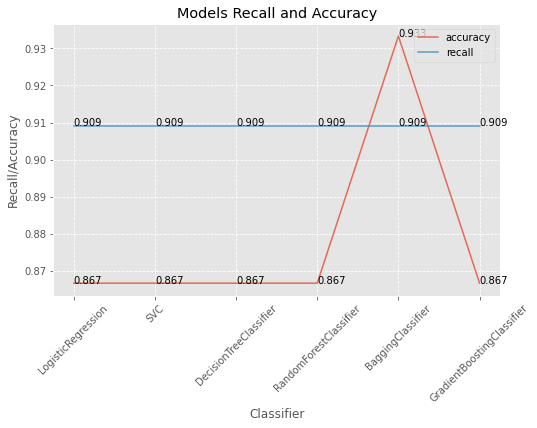

In [32]:
classifiers = {
     'LogisticRegression': lr_clf,
     'SVC': svc_clf,
     'DecisionTreeClassifier': dt_clf,
     'RandomForestClassifier': rf_clf,
     'BaggingClassifier': bg_clf,
     'GradientBoostingClassifier': gb_clf
}

fig, ax_r = plt.subplots(1, 1, figsize=(8, 5))
ax_r.grid(linestyle='--')

ax_r.plot(list(classifiers.keys()), result_ml["accuracy"], label="accuracy", alpha=0.8)
for i,j in zip(classifiers.keys(),result_ml["accuracy"]):
    ax_r.annotate(str(np.round(j,3)),xy=(i,j))
ax_r.plot(list(classifiers.keys()), result_ml["recall"], label="recall", alpha=0.8)
for i,j in zip(classifiers.keys(),result_ml["recall"]):
    ax_r.annotate(str(np.round(j,3)),xy=(i,j))

ax_r.set_title("Models Recall and Accuracy")
ax_r.set_xlabel("Classifier")
ax_r.set_ylabel("Recall/Accuracy")
ax_r.legend(loc="best")
plt.xticks(rotation=45)

plt.show()

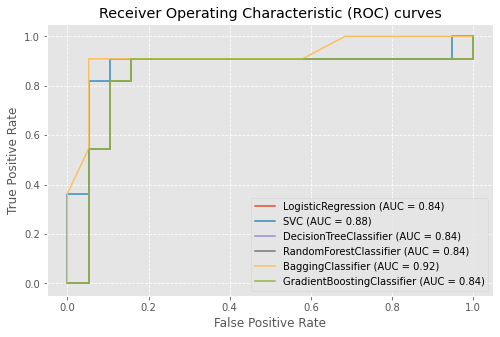

In [33]:
fig, ax_roc = plt.subplots(1, 1, figsize=(8, 5))

for name, clf in classifiers.items():


    plot_roc_curve(clf, x_val, y_val, ax=ax_roc, name=name)

ax_roc.set_title('Receiver Operating Characteristic (ROC) curves')
ax_roc.grid(linestyle='--')
ax_roc.legend(loc="best")
plt.show()

In [29]:
# Сохранение обученных классификаторов
dump(lr_clf, path.join(project_path,'models/lr_clf_model.joblib')) 
dump(svc_clf, path.join(project_path,'models/svc_clf_model.joblib')) 
dump(dt_clf, path.join(project_path,'models/dt_clf_model.joblib')) 
dump(rf_clf, path.join(project_path,'models/rf_clf_model.joblib')) 
dump(bg_clf, path.join(project_path,'models/bg_clf_model.joblib')) 
dump(gb_clf, path.join(project_path,'models/gb_clf_model.joblib')) 

['/content/drive/MyDrive/ML/Volcano/models/gb_clf_model.joblib']

## 4.3 Результаты классификации для тестовой выборки

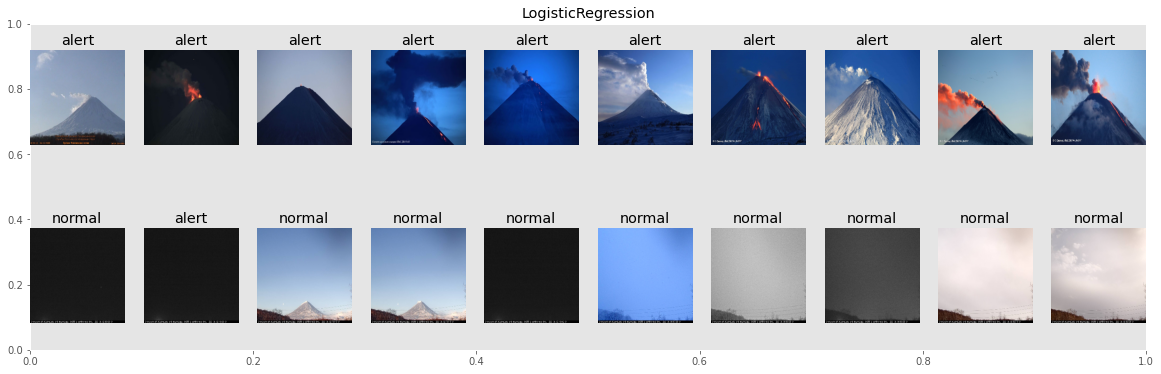

In [34]:
fig = plt.figure(figsize=(20, 6))
plt.title('LogisticRegression')
for i, img in enumerate(test[0:20], 1):
    subplot = fig.add_subplot(2, 10, i)
    plt.imshow(img, cmap='gray');
    plt.axis('off')
    subplot.set_title('%s' % y_predict_test_lr[i - 1]);

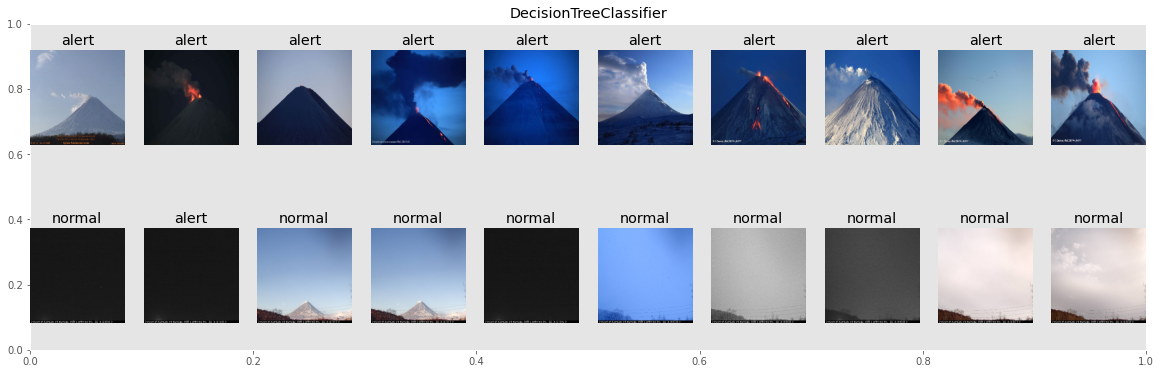

In [35]:
fig = plt.figure(figsize=(20, 6))
plt.title('DecisionTreeClassifier')
for i, img in enumerate(test[0:20], 1):
    subplot = fig.add_subplot(2, 10, i)
    plt.imshow(img, cmap='gray');
    plt.axis('off')
    subplot.set_title('%s' % y_predict_test_dt[i - 1]);

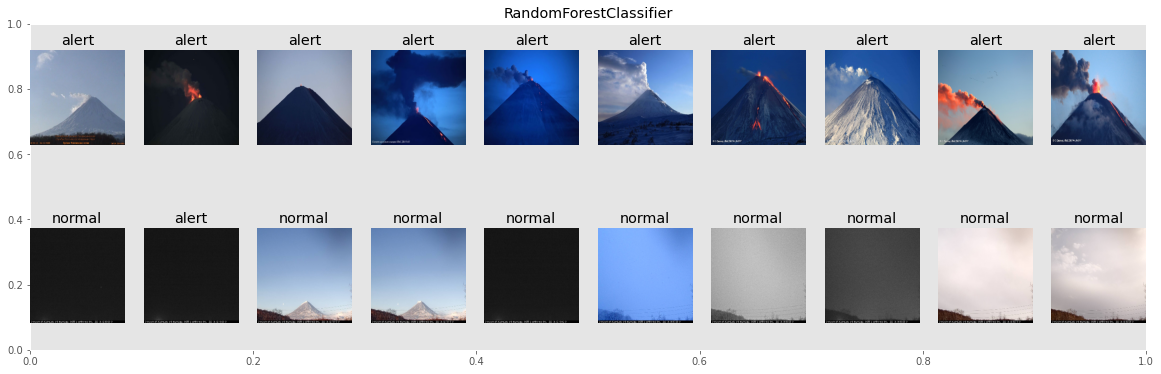

In [36]:
fig = plt.figure(figsize=(20, 6))
plt.title('RandomForestClassifier')
for i, img in enumerate(test[0:20], 1):
    subplot = fig.add_subplot(2, 10, i)
    plt.imshow(img, cmap='gray');
    plt.axis('off')
    subplot.set_title('%s' % y_predict_test_rf[i - 1]);

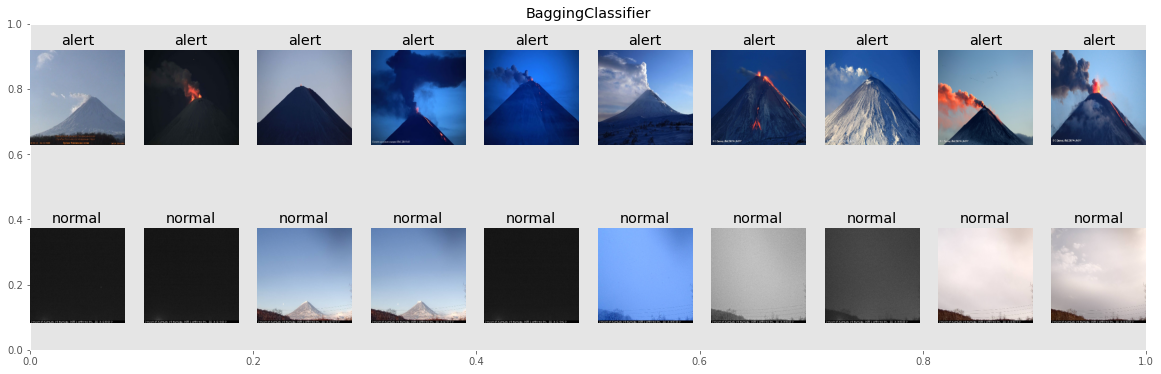

In [37]:
fig = plt.figure(figsize=(20, 6))
plt.title('BaggingClassifier')
for i, img in enumerate(test[0:20], 1):
    subplot = fig.add_subplot(2, 10, i)
    plt.imshow(img, cmap='gray');
    plt.axis('off')
    subplot.set_title('%s' % y_predict_test_bg[i - 1]);

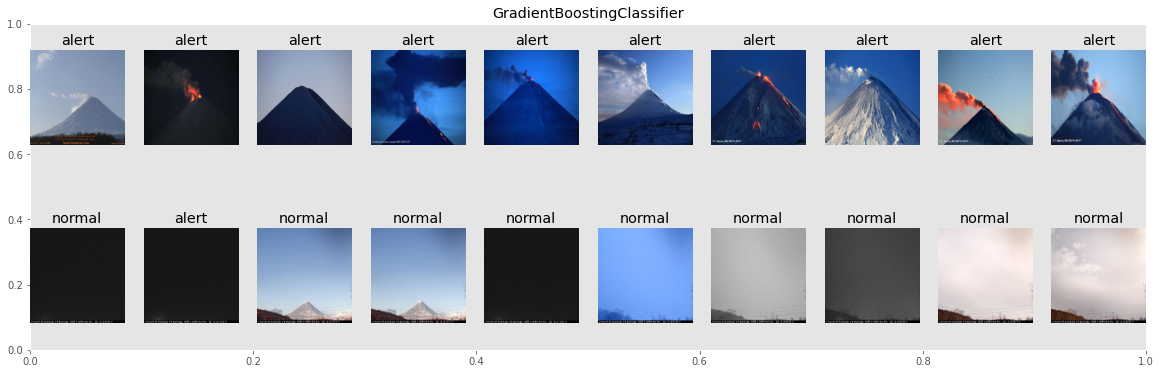

In [38]:
fig = plt.figure(figsize=(20, 6))
plt.title('GradientBoostingClassifier')
for i, img in enumerate(test[0:20], 1):
    subplot = fig.add_subplot(2, 10, i)
    plt.imshow(img, cmap='gray');
    plt.axis('off')
    subplot.set_title('%s' % y_predict_test_gb[i - 1]);

# Deployment

Обработка входного изображения и выдача результата:

In [20]:
lr_clf = load(path.join(project_path,'models/lr_clf_model.joblib')) 
svc_clf = load(path.join(project_path,'models/svc_clf_model.joblib')) 
dt_clf = load(path.join(project_path,'models/lr_clf_model.joblib')) 
rf_clf = load(path.join(project_path,'models/lr_clf_model.joblib')) 
bg_clf = load(path.join(project_path,'models/lr_clf_model.joblib')) 
gb_clf = load(path.join(project_path,'models/lr_clf_model.joblib')) 

Predictions:
['alert']  - RandomForest
['alert']  - Bagging
['alert']  - GradientBoosting
['alert']  - LogisticRegression
['alert']  - DecisionTree


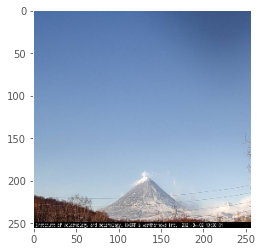

In [39]:
image = load_image(path.join(project_path,'data/raw/img/img.jpg'))


test_grad = np.zeros_like(image)
test_g = np.zeros_like(image).astype(float)
test_theta = np.zeros_like(image).astype(float)

test_g, test_theta = gradient_image_polar(image) 
#test_grad = gradient_image(image)

test_hist = np.zeros(64)
test_hist, borders = np.histogram(test_theta,
                                 bins=64,
                                 range=(0., 2. * np.pi),
                                 weights=test_g)


test_hist = test_hist / np.linalg.norm(test_hist)

test_histogram = []
test_histogram = cd.describe(image)

test_descriptor = np.zeros(34020)
img = cv2.resize(test_grad, (128,128))
h = hog.compute(np.uint8(img))
test_descriptor = h.reshape(-1)


x_test = np.append(test_descriptor,test_hist, axis = 0)

x_test = np.append(x_test, test_histogram, axis = 0).reshape(1, -1)

y_predict_test_rf = rf_clf.predict(x_test)
y_predict_test_bg = bg_clf.predict(x_test)
y_predict_test_gb = gb_clf.predict(x_test)
y_predict_test_lr = lr_clf.predict(x_test)
y_predict_test_dt = dt_clf.predict(x_test)

plt.imshow(image, cmap='gray');
print('Predictions:')
print(y_predict_test_rf,' - RandomForest')
print(y_predict_test_bg,' - Bagging')
print(y_predict_test_gb,' - GradientBoosting')
print(y_predict_test_lr,' - LogisticRegression')
print(y_predict_test_dt,' - DecisionTree')

Для массива фото:

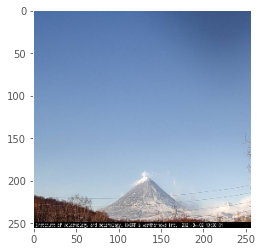

Predictions:
alert  - RandomForest
alert  - Bagging
alert  - GradientBoosting
alert  - LogisticRegression
alert  - DecisionTree


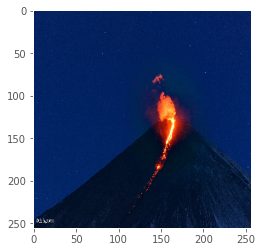

Predictions:
alert  - RandomForest
alert  - Bagging
alert  - GradientBoosting
alert  - LogisticRegression
alert  - DecisionTree


In [40]:
# load images for predict
images = []
imagePaths = [path.join(project_path,'data/raw/img/img.jpg'),path.join(project_path,'data/raw/img/img2.jpg')]
for imagePath in imagePaths:
    image = load_image(imagePath)
    images.append(image)


images_grad = np.zeros_like(images)
images_g = np.zeros_like(images).astype(float)
images_theta = np.zeros_like(images).astype(float)

# calculate histogram of gradients
for i in range(len(images)):
    images_g[i], images_theta[i] = gradient_image_polar(images[i])     # applay Sobel filters and convert to polar coordinate to calculate histogram of gradient
    # images_grad[i] = gradient_image(images[i])      # applay Gaussian filters,  calculate gradients  - didn't use for fit model

images_hist = np.zeros((len(images), 64))
for i in range(len(images)):
    hist, borders = np.histogram(images_theta[i],
                                 bins=64,
                                 range=(0., 2. * np.pi),
                                 weights=images_g[i])

    images_hist[i] = hist

images_hist = images_hist / np.linalg.norm(images_hist, axis=1)[:, None]

# calculate color descriptor
images_histogram = []
for i in range(len(images)):
    images_histogram.append(cd.describe(images[i]))

 # calculate hog descriptor
images_descriptor = np.zeros((len(images_grad), 34020))  
for i in range(len(images_grad)):
    img = cv2.resize(images_grad[i], (128,128))
    h = hog.compute(np.uint8(img))
    images_descriptor[i] = h.reshape(-1)

# combine all descriptor
x_test = np.hstack((images_descriptor, images_hist))  
x_test = np.hstack((x_test,images_histogram))

# get predict
y_predict_test_rf = rf_clf.predict(x_test)
y_predict_test_bg = bg_clf.predict(x_test)
y_predict_test_gb = gb_clf.predict(x_test)
y_predict_test_lr = lr_clf.predict(x_test)
y_predict_test_dt = dt_clf.predict(x_test)

for i in range(len(images)): 
  plt.imshow(images[i], cmap='gray');
  plt.show()
  print('Predictions:')
  print(y_predict_test_rf[i],' - RandomForest')
  print(y_predict_test_bg[i],' - Bagging')
  print(y_predict_test_gb[i],' - GradientBoosting')
  print(y_predict_test_lr[i],' - LogisticRegression')
  print(y_predict_test_dt[i],' - DecisionTree')
